# Pittsburgh's Next Top Neighborhood

## 🚗 Commutability

In [1]:
import pandas as pd

# read census data
data = pd.read_csv("data/SNAP/Neighborhoods_with_SNAP_data.csv")

# make easier column names
data['name'] = data['Neighborhood_2010_HOOD']             # neighborhood name
data['drive'] = data['SNAP_All_csv_Commute_to_Work__D']   # drive to work alone
data['carpool'] = data['SNAP_All_csv_Commute_to_Work__C'] # carpool/vanpool
data['public'] = data['SNAP_All_csv_Commute_to_Work__P']  # public transit
data['taxi'] = data['SNAP_All_csv_Commute_to_Work__T']    # taxi
data['motor'] = data['SNAP_All_csv_Commute_to_Work__M']   # motorcycle
data['bike'] = data['SNAP_All_csv_Commute_to_Work__B']    # bike
data['walk'] = data['SNAP_All_csv_Commute_to_Work__W']    # walk
data['other'] = data['SNAP_All_csv_Commute_to_Work__O']   # other

# clean data
data = data.fillna(0)

# constants to determine value of method
# best values are 1, okay are 0.5, bad or null are 0.25
good = 1   # bike, walk
okay = 0.5 # carpool, public transit
bad = 0.25 # drive, taxi, motorcycle, other

# convert percent value to float
def convert(value):
    value = str(value)
    value = value.replace('%','')
    return float(value)

# iterate through rows, calculate commutability score
for idx, row in data.iterrows():
    score = convert(data.loc[idx,'bike']) + convert(data.loc[idx, 'walk']) # good methods
    score += okay*(convert(data.loc[idx, 'carpool']) + convert(data.loc[idx, 'public'])) # okay methods
    score += bad*(convert(data.loc[idx, 'drive']) + convert(data.loc[idx, 'taxi']) + convert(data.loc[idx, 'motor']) + convert(data.loc[idx, 'other'])) # bad methods
    data.at[idx,'raw'] = score # set neighborhood's commutability score


# find score using Pawel's formula
data['score'] = data['raw']/data['raw'].max()

# create results dataframe
commute = data[['name','score']] # create dataframe
commute = commute.sort_values(by=['name']).set_index('name') # sort and set name index
commute # print table

,score
name,
Allegheny Center,0.836108
Allegheny West,0.698008
Allentown,0.480248
Arlington,0.405158
Arlington Heights,0.616716
...,...
Upper Lawrenceville,0.464577
West End,0.433562
West Oakland,0.801828


In [2]:
data['name'] = data['Neighborhood_2010_HOOD']    
data['score'] = (-1)* data['SNAP_All_csv_Part_1_Crime_per_1']/(data['SNAP_All_csv_Part_1_Crime_per_1'].max())

data['score'] = (((1)* data['SNAP_All_csv_Part_1_Crime_per_1']/(data['SNAP_All_csv_Part_1_Crime_per_1'].max())) + ((0.5)* data['SNAP_All_csv_Part_2_Crime_per_1']/(data['SNAP_All_csv_Part_2_Crime_per_1'].max()))) / data['Pop__2010'] * 10 
data['score'] = data['score']/data['score'].max() 
crime = data[['name','score']].sort_values(by ='score',ascending=True)

#sort alphabetically 
crime = crime.sort_values(by=['score']) # sort and set name index
crime = crime.reset_index(drop = True)

crime








,name,score
0,Squirrel Hill North,0.000007
1,Squirrel Hill South,0.000009
2,North Oakland,0.000010
3,Brookline,0.000011
4,Greenfield,0.000019
...,...,...
85,Esplen,0.002966
86,West End,0.003189
87,North Shore,0.005239
88,South Shore,0.794693


# 🌳 Trees

In [3]:
#import data from csv
t = pd.read_csv("data/trees_data.csv")
trees = t.iloc[:,[48,3,15,16,17,19,20,37,38,39,47]].dropna().sort_values("neighborhood") #isolate just the columns I care about into one dataframe.
trees.head(10)

#Isolate each unique neighborhood
n = trees["neighborhood"].unique().tolist()

#change neighborhood column in dataframe to the indicies
for thing in n :
    trees = trees.replace([thing], n.index(thing))
    
#Function to collect all of the values in a certain column for each neighborhood.
def statsGrab(c, df) :
    statList = []
    stat = 0
    index = 0
    for r in range (len(df)) :
        if (df.iloc[r,0] == index) :
            stat += float(df.iloc[r,c])
        else :
            statList.append(stat)
            index+=1
            stat = float(df.iloc[r,c])
    statList.append(stat)
    return statList

stormValue = statsGrab(2, trees) #Isolate column 2 with storm value dollar benefits
propValue = statsGrab(4, trees) #Isolate column 4 with property value benefits
elecValue = statsGrab(5, trees) #Isolate column 5 with electricity value benefits
airValue = statsGrab(7, trees) #Isolates column 7 with air quality value benefits

#the data is in the wrong orientation for a dataframe. Time to rework it...
index = []
scoresList = [[]]
for i in range(90) :  
    index.append(i)
    
    scoresList[i].append(n[i])
    scoresList[i].append(stormValue[i])
    scoresList[i].append(propValue[i])
    scoresList[i].append(elecValue[i])
    scoresList[i].append(airValue[i])
    
    scoresList.insert(i+1, [])
    
del scoresList[90]
    
scores = pd.DataFrame(scoresList,
                      columns = ['Neighborhood', 'Stormwater Benefits', 'Property Value', 'Electric Benefits', 'Air Quality Benefits'], index=index)

stormRank = []
propRank = []
elecRank = []
airRank = []

for r in range(90) :
    stormRank.append(0)
    propRank.append(0)
    elecRank.append(0)
    airRank.append(0)

#sort each of the sheets by the values (lowest to highest)
sScores = scores.sort_values("Stormwater Benefits")
pScores = scores.sort_values("Property Value")
eScores = scores.sort_values("Electric Benefits")
aScores = scores.sort_values("Air Quality Benefits")

for r in range(90) : #assign ranks with 90 at the lowest and 1 at the highest dollar value
    i = sScores.index.tolist()
    stormRank[i[r]] = (90-r)
    
    i = pScores.index.tolist()
    propRank[i[r]] = (90-r)
    
    i = eScores.index.tolist()
    elecRank[i[r]] = (90-r)
    
    i = aScores.index.tolist()
    airRank[i[r]] = (90-r)
    
#Once again, the data is in the wrong orientation for a dataframe, but I want to plot it before determining final scores.
index = []
scoresList = [[]]
for i in range(90) :  
    index.append(i)
    
    scoresList[i].append(n[i])
    scoresList[i].append(stormRank[i])
    scoresList[i].append(propRank[i])
    scoresList[i].append(elecRank[i])
    scoresList[i].append(airRank[i])
    
    scoresList.insert(i+1, [])
    
del scoresList[90]
    
rank = pd.DataFrame(scoresList,
                      columns = ['Neighborhood', 'Stormwater Rank', 'Property Rank', 'Electric Rank', 'Air Quality Rank'], index=index)

C:\Users\hunte\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Here's how each neighborhood ranks! The smaller the bar, the better the rank.

<AxesSubplot:xlabel='Neighborhood'>

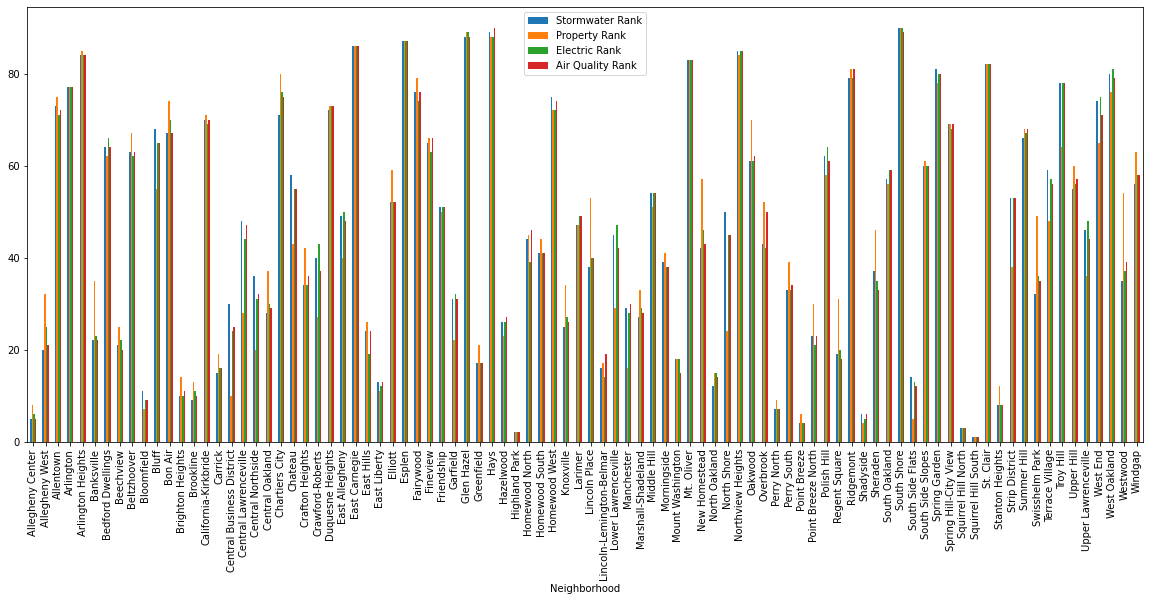

In [4]:
rank.plot.bar(x='Neighborhood', figsize=(20,8))

In [5]:
nRank = []
for r in range(90) :
    rankSum = stormRank[r] + propRank[r] + elecRank[r] + airRank[r]
    nRank.append(rankSum)
    
index = []
rank = [[]]
for i in range(90) :  
    index.append(i)
    
    rank[i].append(n[i])
    rank[i].append(nRank[i])
    
    rank.insert(i+1, [])
    
del rank[90]
    
rank = pd.DataFrame(rank,
                      columns = ['Neighborhood', 'Rank'], index=index)

rank = rank.sort_values('Rank')

#For importing into final.ipynb

rankList = []
for r in range(90) :
    rankList.append(0)
    
i = rank.index.tolist()
for r in range(90) :
    rankList[i[r]] = (r+1)

scoresList = [[]]
for i in range(90) :      
    scoresList[i].append(n[i])
    scoresList[i].append(rankList[i])
    
    scoresList.insert(i+1, [])
    
del scoresList[90]

finalRank = pd.DataFrame(scoresList, columns=['Neighborhood', 'Rank']).sort_values("Rank")
finalRank.head(10)

,Neighborhood,Rank
76,Squirrel Hill South,1
39,Highland Park,2
75,Squirrel Hill North,3
62,Point Breeze,4
67,Shadyside,5
0,Allegheny Center,6
60,Perry North,7
78,Stanton Heights,8
9,Bloomfield,9
13,Brookline,10
